In [ ]:
!pip install google-cloud-aiplatform google-cloud-storage
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Attention, Input
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from datetime import datetime
import gc
import psutil

In [ ]:
from google.cloud import storage

BUCKET_NAME = "gold_predictions_web"  # เปลี่ยนเป็นชื่อ Bucket ของคุณ

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
print(f"เชื่อมต่อกับ GCS Bucket: {BUCKET_NAME}")

เชื่อมต่อกับ GCS Bucket: gold_predictions_web


In [ ]:
import requests
nowDate=datetime.now()
startTime=f'{nowDate.year-15}-{nowDate.month}-{nowDate.day}'
endTime=f'{nowDate.year}-{nowDate.month}-{nowDate.day}'
startTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year-15}'
endTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year}'
url_currency = f"https://gold-predictions.duckdns.org/currency/get/?start={startTime}&end={endTime}&cache=False"
url_Gold_usd = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=1&start={startTime_1}&end={endTime_1}&cache=False"
url_Gold_thb = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=0&start={startTime_1}&end={endTime_1}&cache=False"
# เรียก API และดึงข้อมูล
response = requests.get(url_currency)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_currency = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_currency["data"]
    df_currency = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_currency.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_usd)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_usd = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_usd["data"]
    df_Gold_usd = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_usd.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_thb)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_thb = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_thb["data"]
    df_Gold_thb = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_thb.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

df_currency=df_currency[['date','price']]
df_currency.columns = ['Date', 'price_exchange']

df_Gold_thb=df_Gold_thb[['timestamp','price']]
df_Gold_thb = df_Gold_thb.copy()
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_thb['timestamp'] = pd.to_datetime(df_Gold_thb['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_thb.columns = ['Date', 'Thai_Gold']

df_Gold_usd=df_Gold_usd[['timestamp','close_price']]
df_Gold_usd = df_Gold_usd.copy()
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_usd['timestamp'] = pd.to_datetime(df_Gold_usd['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_usd.columns = ['Date', 'Xau']


# รวม DataFrame ทั้งสามโดยใช้ date เป็นคีย์อ้างอิง
df_currency['Date'] = pd.to_datetime(df_currency['Date'], format='%Y-%m-%d').dt.normalize()
df_Gold_thb['Date'] = pd.to_datetime(df_Gold_thb['Date'], format='%d/%m/%Y').dt.normalize()
df_Gold_usd['Date'] = pd.to_datetime(df_Gold_usd['Date'], format='%d/%m/%Y').dt.normalize()
merged_df = (
    df_Gold_thb
    .merge(df_Gold_usd, on='Date', how='outer')
    .merge(df_currency, on='Date', how='outer')
)
merged_df = (
    merged_df
    .sort_values('Date')
    .groupby('Date', as_index=False)
    .first()  # เอาแถวแรกของแต่ละวัน
)
print(df_currency.dtypes)
print(df_Gold_thb.dtypes)
print(df_Gold_usd.dtypes)

merged_df[['Xau']] = merged_df[['Xau']].shift(1)
merged_df['Xau'] = merged_df['Xau'].ffill()
merged_df.dropna(inplace=True)
merged_df.to_csv('acvs.csv')
dupes = merged_df[merged_df.duplicated('Date', keep=False)]
print(f"จำนวนวันที่ซ้ำ: {len(dupes)}")
print(dupes.sort_values('Date'))

          id        date  price   open    high     low  percent  diff
6884  194967  2025-04-17  33.34  33.10  33.445  33.055   0.8164  0.27
6885  194968  2025-04-18  33.35  33.35  33.460  32.950   0.0300  0.01
6886  194970  2025-04-19  33.39  33.35  33.450  33.320   0.1100  0.04
6887  194971  2025-04-20  33.38  33.39  33.440  33.310  -0.0400 -0.01
6888  194972  2025-04-21  33.07  33.35  33.350  33.050  -0.9300 -0.31
         id      timestamp    price  close_price  high_price  low_price  \
3041  90318  1744502400000  3238.07      3223.90     3238.07    3210.60   
3042  90319  1744588800000  3221.80      3212.34     3245.23    3194.59   
3043  90320  1744675200000  3212.71      3250.51     3250.80    3210.20   
3044  90323  1744761600000  3252.86      3349.52     3357.01    3250.34   
3045  90325  1744848000000  3349.87      3314.93     3355.33    3276.44   

      volume  volume_weight_avg  num_transactions      date  \
3041   262.0          3219.8965               262  13-04-25   
304

📂 พบโฟลเดอร์ models_month, กำลังย้ายไฟล์ไปที่ models_month_old...
✅ ย้าย models_month/Model_month.keras -> models_month_old/Model_month.keras
🗑️ ลบไฟล์เก่า models_month/Model_month.keras
✅ ย้าย models_month/actual_vs_predict_Max.png -> models_month_old/actual_vs_predict_Max.png
🗑️ ลบไฟล์เก่า models_month/actual_vs_predict_Max.png
✅ ย้าย models_month/actual_vs_predict_Min.png -> models_month_old/actual_vs_predict_Min.png
🗑️ ลบไฟล์เก่า models_month/actual_vs_predict_Min.png
✅ ย้าย models_month/actual_vs_predict_Open.png -> models_month_old/actual_vs_predict_Open.png
🗑️ ลบไฟล์เก่า models_month/actual_vs_predict_Open.png
✅ ย้าย models_month/history_loss.png -> models_month_old/history_loss.png
🗑️ ลบไฟล์เก่า models_month/history_loss.png
✅ ย้าย models_month/model_metrics_Month.csv -> models_month_old/model_metrics_Month.csv
🗑️ ลบไฟล์เก่า models_month/model_metrics_Month.csv
🎉 ย้ายไฟล์ทั้งหมดจาก models_month -> models_month_old สำเร็จ!
            Thai_Gold_Open  Thai_Gold_Max  Thai_Gold_Min

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - loss: 0.0291 - val_loss: 0.1556 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0284 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0226 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0227 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0228 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0243 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0185 - val_loss: 0.1030 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0141 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0141 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

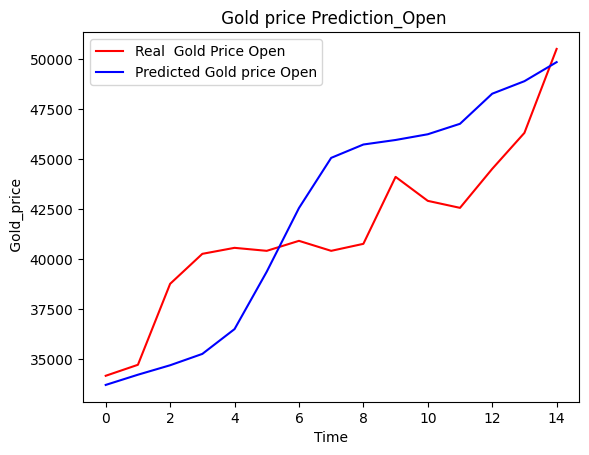

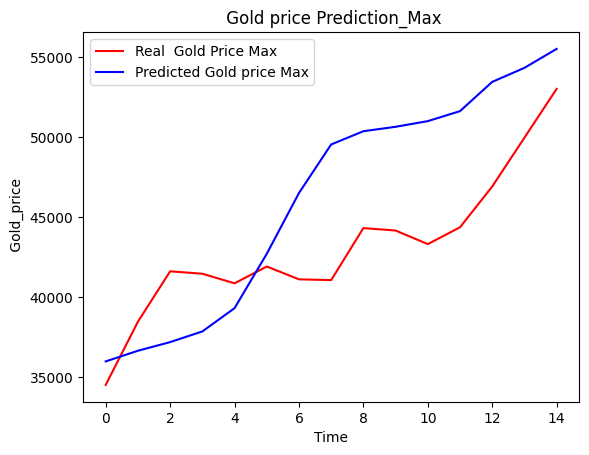

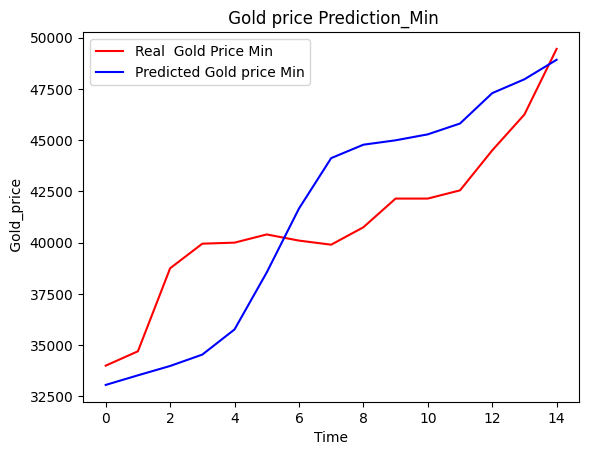

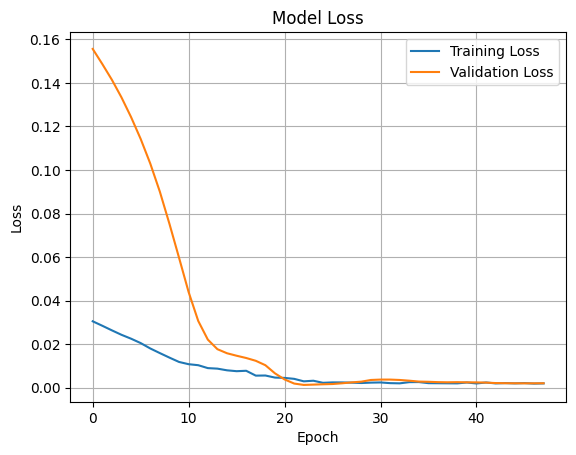

In [ ]:
BUCKET_NAME = "gold_predictions_web"  # เปลี่ยนเป็นชื่อ bucket ของคุณ
OLD_FOLDER = "models_month"
NEW_FOLDER = "models_month_old"


blobs = list(bucket.list_blobs(prefix=f"{OLD_FOLDER}/"))

if blobs:  # ถ้ามีไฟล์ในโฟลเดอร์ "models"
    print(f"📂 พบโฟลเดอร์ {OLD_FOLDER}, กำลังย้ายไฟล์ไปที่ {NEW_FOLDER}...")

    for blob in blobs:
        # ตั้งค่า path ใหม่
        new_blob_name = blob.name.replace(OLD_FOLDER, NEW_FOLDER, 1)

        # คัดลอกไฟล์ไปยังตำแหน่งใหม่
        new_blob = bucket.copy_blob(blob, bucket, new_blob_name)
        print(f"✅ ย้าย {blob.name} -> {new_blob_name}")

        # ลบไฟล์เก่าหลังจากคัดลอกเสร็จ
        blob.delete()
        print(f"🗑️ ลบไฟล์เก่า {blob.name}")

    print(f"🎉 ย้ายไฟล์ทั้งหมดจาก {OLD_FOLDER} -> {NEW_FOLDER} สำเร็จ!")
else:
    print(f"❌ ไม่พบโฟลเดอร์ {OLD_FOLDER} ใน GCS")
movingavg=[0]
lag=[3]
seq=[1]
month_data=[True]
# Load the data
for month_onoff in range(len(month_data)):

    data = merged_df.copy()

# Convert 'Date' to datetime format
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

    # Remove commas from the 'Xau' column and convert to float
    # data['Xau'] = data['Xau'].str.replace(',', '').astype(float)

    # Set 'Date' as the index
    data.set_index('Date', inplace=True)

    # Resample to monthly data and calculate open, max, and min for Thai_Gold
    monthly_data = data.resample('ME').agg({
        'Thai_Gold': ['first', 'max', 'min'],
        'price_exchange': 'mean',
        'Xau': 'mean'
    })

    # Rename columns for clarity
    monthly_data.columns = [
        'Thai_Gold_Open', 'Thai_Gold_Max', 'Thai_Gold_Min',
        'Price_Exchange_Mean', 'Xau_Mean'
    ]

    # Add the correct 'Thai_Gold_Open' for the first day of each month
    first_of_month = data.resample('MS').first()['Thai_Gold']
    monthly_data['Thai_Gold_Open'] = first_of_month.values

    # Add a 'Month' column with numeric month values
    if month_data[month_onoff] == True:
      monthly_data['Month'] = monthly_data.index.strftime('%m')

    # Calculate moving averages for 3, 5, and 7 months
    for moving_num in range(len(movingavg)):
      if movingavg[moving_num] >=1:
        monthly_data['MA_3'] = monthly_data['Thai_Gold_Open'].rolling(window=3).mean()
      if movingavg[moving_num] >=2:
        monthly_data['MA_5'] = monthly_data['Thai_Gold_Open'].rolling(window=5).mean()
      if movingavg[moving_num] >=3:
        monthly_data['MA_7'] = monthly_data['Thai_Gold_Open'].rolling(window=7).mean()
      # Rearrange columns

      # Display the final DataFrame
      monthly_data.dropna(inplace=True)
      print(monthly_data)
      # Feature=['Month','Price_Exchange_Mean', 'Xau_Mean', 'MA_3', 'MA_5', 'MA_7']
      Target=['Thai_Gold_Open', 'Thai_Gold_Max', 'Thai_Gold_Min']
      data_clone=monthly_data.copy()
      for lagFea in range(len(lag)):
        X = monthly_data.drop(columns=Target)
        y = monthly_data[Target].values
        for i in range(1, lag[lagFea]+1):  # สร้างย้อนหลัง 7 วัน
            X[f'Thai_Gold_Open_Lag_{i}'] = data_clone['Thai_Gold_Open'].shift(i)
            X[f'Thai_Gold_Max_Lag_{i}'] = data_clone['Thai_Gold_Max'].shift(i)
            X[f'Thai_Gold_Min_Lag_{i}'] = data_clone['Thai_Gold_Min'].shift(i)
        ASD=y
        X = X.dropna().reset_index(drop=True)
        y = np.array(y, dtype=np.float64)

        # ลบ 3 index แรก
        y = y[lag[lagFea]:]
        scaler_X = MinMaxScaler(feature_range=(0,1))
        scaler_y = MinMaxScaler(feature_range=(0,1))
        X = scaler_X.fit_transform(X)
        y = scaler_y.fit_transform(y)
        print(len(y))
        for lookbackFea in range(len(seq)):
          def create_sequences(X, y, lookback, n_future):
              X_seq, y_seq = [], []
              for i in range(len(X) - lookback - n_future):
                  X_seq.append(X[i:i+lookback])
                  y_seq.append(y[i+lookback+n_future])
                  print(i+lookback+n_future)
              return np.array(X_seq), np.array(y_seq)
          lookback = seq[lookbackFea]  # ดูย้อนหลัง 30 วัน
          n_future = 1   # พยากรณ์ 7 วันข้างหน้า   # พยากรณ์ 7 วันข้างหน้า
          X_seq, y_seq = create_sequences(X, y, lookback, n_future)

          # กำหนดขนาดข้อมูล
          test_size = 15     # ขนาด Test Set
          val_size = 20      # ขนาด Validation Set
          train_size = X_seq.shape[0] - (val_size + test_size)  # ขนาด Training Set

          # แบ่งข้อมูลเป็น Training, Validation และ Test ตามลำดับเวลา
          X_train, y_train = X_seq[:train_size], y_seq[:train_size]
          X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
          X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

          # ตรวจสอบขนาดของชุดข้อมูล
          print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
          print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
          print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

          # สร้างโมเดล LSTM
          model = Sequential([
              LSTM(64,return_sequences=True, input_shape=(lookback, X_seq.shape[2]), activation='relu'),
              LSTM(64, return_sequences=True),
              LSTM(32, return_sequences=False),
              (Dropout(0.2)),
              # Dense(16),
              Dense(3)  # Output ขนาด 7 (พยากรณ์ 7 วัน)
          ])
          model.compile(optimizer='adam', loss='mse')

          # Callbacks
          early_stop = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
          reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

          # Train โมเดล
          metrics_list = []
          predict_list=[]
          ori_list=[]
          # เทรนโมเดล 5 รอบ
          models = []
          histo=[]
          for loopTrain in range(10):
            history = model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=100,
                batch_size=32,
                callbacks=[early_stop, reduce_lr]
            )

            # พยากรณ์
            predictions = model.predict(X_test)

            # แปลงผลลัพธ์กลับสู่สเกลเดิม
            y_test_original = scaler_y.inverse_transform(y_test)
            predictions_original = scaler_y.inverse_transform(predictions)
            ori_list.append(y_test_original)
            predict_list.append(predictions_original)
            histo.append(history)
            # ดูผลลัพธ์
            print("Actual Values (7 days):", y_test_original[14])
            print("Predicted Values (7 days):", predictions_original[14])
            def mean_absolute_percentage_error(y_true, y_pred):
                y_true, y_pred = np.array(y_true), np.array(y_pred)
                return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            mape = mean_absolute_percentage_error(y_test_original, predictions_original)*100
            rmse =root_mean_squared_error(y_test_original, predictions_original)
            r2=r2_score(y_test_original, predictions_original)
            models.append(model)
            metrics_list.append((r2, rmse, mape))

          metrics_array = np.array(metrics_list)

          # Normalize ตัวชี้วัด
          min_r2, max_r2 = metrics_array[:, 0].min(), metrics_array[:, 0].max()
          min_rmse, max_rmse = metrics_array[:, 1].min(), metrics_array[:, 1].max()
          min_mape, max_mape = metrics_array[:, 2].min(), metrics_array[:, 2].max()

          normalized_metrics = np.zeros_like(metrics_array)

          # Normalize R² (ค่ามากขึ้น = ดีขึ้น)
          normalized_metrics[:, 0] = (metrics_array[:, 0] - min_r2) / (max_r2 - min_r2 + 1e-8)

          # Normalize RMSE และ MAPE (ค่าน้อยลง = ดีขึ้น)
          normalized_metrics[:, 1] = (max_rmse - metrics_array[:, 1]) / (max_rmse - min_rmse + 1e-8)
          normalized_metrics[:, 2] = (max_mape - metrics_array[:, 2]) / (max_mape - min_mape + 1e-8)

          # คำนวณคะแนนรวม (ให้ R² น้ำหนักมากที่สุด)
          score = 0.4 * normalized_metrics[:, 0] + 0.3 * normalized_metrics[:, 1] + 0.3 * normalized_metrics[:, 2]

          # เลือกโมเดลที่มีคะแนนรวมดีที่สุด
          best_idx = np.argmax(score)
          best_model = models[best_idx]
          best_ori = ori_list[best_idx]
          best_predict = predict_list[best_idx]
          best_history = histo[best_idx]

          local_path1 = f"actual_vs_predict_Open.png"
          local_path2 = f"actual_vs_predict_Max.png"
          local_path3 = f"actual_vs_predict_Min.png"
          local_path4 = f"history_loss.png"

          DESTINATION_PATH1 = f"{OLD_FOLDER}/actual_vs_predict_Open.png"
          DESTINATION_PATH2 = f"{OLD_FOLDER}/actual_vs_predict_Max.png"
          DESTINATION_PATH3 = f"{OLD_FOLDER}/actual_vs_predict_Min.png"
          DESTINATION_PATH4 = f"{OLD_FOLDER}/history_loss.png"

          plt.plot(best_ori[:,0], color = 'red', label = 'Real  Gold Price Open')
          plt.plot(best_predict[:,0], color = 'blue', label = 'Predicted Gold price Open')
          plt.title(f' Gold price Prediction_Open')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          plt.savefig(local_path1)
          plt.show()

          plt.plot(best_ori[:,1], color = 'red', label = 'Real  Gold Price Max')
          plt.plot(best_predict[:,1], color = 'blue', label = 'Predicted Gold price Max')
          plt.title(f' Gold price Prediction_Max')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          plt.savefig(local_path2)
          plt.show()

          plt.plot(best_ori[:,2], color = 'red', label = 'Real  Gold Price Min')
          plt.plot(best_predict[:,2], color = 'blue', label = 'Predicted Gold price Min')
          plt.title(f' Gold price Prediction_Min')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          plt.savefig(local_path3)
          plt.show()

          plt.plot(best_history.history['loss'], label='Training Loss')
          plt.plot(best_history.history['val_loss'], label='Validation Loss')
          plt.title('Model Loss')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.grid(True)
          plt.savefig(local_path4)
          plt.show()

          client = storage.Client()
          bucket = client.bucket(BUCKET_NAME)
          blob = bucket.blob(DESTINATION_PATH1)
          blob.upload_from_filename(local_path1)
          blob = bucket.blob(DESTINATION_PATH2)
          blob.upload_from_filename(local_path2)
          blob = bucket.blob(DESTINATION_PATH3)
          blob.upload_from_filename(local_path3)
          blob = bucket.blob(DESTINATION_PATH4)
          blob.upload_from_filename(local_path4)
          best_model.save(f'gs://{BUCKET_NAME}/{OLD_FOLDER}/Model_month.keras',overwrite=True)
          results = pd.DataFrame({
          'Metric': ['RMSE', 'MAPE', 'R2'],
          'Value': [metrics_array[best_idx][1], metrics_array[best_idx][2], metrics_array[best_idx][0]]
          })
          results.to_csv(f'gs://{BUCKET_NAME}/{OLD_FOLDER}/model_metrics_Month.csv', index=False)
          # monthly_data.to_csv(f'{folder_path}/monthly_data.csv')

In [ ]:
df_open=pd.DataFrame({'actual':best_ori[:,0],'predict':best_predict[:,0]})
df_high=pd.DataFrame({'actual':best_ori[:,1],'predict':best_predict[:,1]})
df_low=pd.DataFrame({'actual':best_ori[:,2],'predict':best_predict[:,2]})

In [ ]:
df_open.to_csv('open.csv')
df_high.to_csv('high.csv')
df_low.to_csv('low.csv')